# Gold Recovery from Ore

## Description

<br><b>Aim</b>

To prepare a prototype machine learning model that predicts the gold recovery rate from gold-bearing ore.

<br><b>Background</b>

Extracting gold from ore:

1. Flotation:
mixture + enrichment --> rough concentrate + tailings
2. Cleaning:
   1. First cleaning: rough concentrate --> concentrate after the first cleaning + tailings
   2. Second cleaning: concentrate after the first cleaning --> final concentrate + tailings


The model will help optimize production to avoid running operations with unprofitable characteristics. The process of gold recovery from gold-bearing ore needs to be modeled. To do this, the enrichment efficiency must be calculated – it's necessary to determine the gold share in concentrates and tailings. Not only the final product is important, but also the rough concentrate.

Enrichment efficiency is calculated by the formula:

    recovery = (((C*(F-T))/((F*(C-T))))* 100%

where:

   - C — gold share in the concentrate after flotation/cleaning;
   - F — gold share in raw material/concentrate before flotation/cleaning;
   - T — gold share in tailings after flotation/cleaning.

Quality metric — sMAPE (Symmetric Mean Absolute Percentage Error).

It's necessary to forecast two quantities:
- rougher concentrate enrichment efficiency rougher.output.recovery;
- final concentrate enrichment efficiency final.output.recovery.

The final sMAPE is a combination of two values:
- Final sMAPE = 25% * sMAPE(rougher) + 75% * sMAPE(final)

<br><b>Data Description</b>

Technological Process
- Rougher feed — raw material
- Rougher additions (или reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant
- Xanthate — xanthogenate (promoter or flotation activator)
- Sulphate — sulphate (sodium sulphide in this production)
- Depressant — depressant (sodium silicate)
- Rougher process — flotation
- Rougher tails — tailings
- Float banks — flotation unit
- Cleaner process — cleaning
- Rougher Au — rough gold concentrate
- Final Au — final gold concentrate

Stage Parameters
- air amount — air volume
- fluid levels — liquid level
- feed size — raw material granule size
- feed rate — feed speed

## Data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ydata_profiling

from scipy.stats import ks_2samp
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
from ydata_profiling import ProfileReport

import warnings
warnings.simplefilter("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

In [2]:
try:
    train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv')
except:
    train = pd.read_csv('gold_recovery_train_new.csv')
    
try:
    test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv')
except:
    test = pd.read_csv('gold_recovery_test_new.csv')
    
try:
    full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv')
except:
    full = pd.read_csv('gold_recovery_full_new.csv')

In [3]:
# Opening the training dataset
profile_train = ProfileReport(train, minimal=True)
profile_train

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

ValueError: Only supported for TrueType fonts

<Figure size 432x288 with 0 Axes>

In [4]:
# Opening the test dataset
profile_test = ProfileReport(test, minimal=True)
profile_test

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

ValueError: Only supported for TrueType fonts

<Figure size 432x288 with 0 Axes>

In [5]:
# Opening the full database
profile_full = ProfileReport(full, minimal=True)
profile_full

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

ValueError: Only supported for TrueType fonts

<Figure size 432x288 with 0 Axes>

Upon the initial data analysis, we observe the following:

- The full dataset contains 87 columns, while the test set has 53;
- No duplicates are present in the datasets;
- Missing values constitute an extremely small percentage overall (from less than 0.1% to a maximum of 0.3%). However, some columns have 9-11% missing values. Given that temporally adjacent parameters are often similar, the 'ffill' method can be employed to fill in the gaps using the previous row's value;
- The 'date' column is of the 'object' type and should be converted to 'datetime'.

In [6]:
# Changing the date column type
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%dT%H:%M')
full['date'] = pd.to_datetime(full['date'], format='%Y-%m-%dT%H:%M')
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%dT%H:%M')

In [7]:
# Handling missing values
train.ffill(axis='rows', inplace=True)
full.ffill(axis='rows', inplace=True)
test.ffill(axis='rows', inplace=True)

At this stage, our task is to verify that the enrichment efficiency is calculated correctly.

For this, it needs to be computed on the training dataset for the feature 'rougher.output.recovery' and determine the MAE (Mean Absolute Error) between the computations and the feature value.

Recall the enrichment efficiency formula:

recovery = (((C*(F-T))/((F*(C-T)))* 100%
где:

- C — gold content in the concentrate post-flotation/cleaning;
- F — gold content in the raw material/concentrate pre-flotation/cleaning;
- T — gold content in tailings post-flotation/cleaning.

In our database:
- C — rougher.output.concentrate_au;
- F — rougher.input.feed_au;
- T — rougher.output.tail_au.

The computations should be compared to the 'rougher.output.recovery' feature.

In [8]:
# We will create a function to calculate the enrichment efficiency.

def recovery(c,f,t):
    recovery = (((c*(f-t)))/((f*(c-t))))*100
    return recovery

In [9]:
c = train['rougher.output.concentrate_au']
f = train['rougher.input.feed_au']
t = train['rougher.output.tail_au']

recovery_train = train['rougher.output.recovery']
recovery_train_calc = recovery(c,f,t)

mae = mean_absolute_error(recovery_train, recovery_train_calc)
print('Mean Absolute Error:', mae)

Mean Absolute Error: 9.73512347450521e-15


In [10]:
set(train.columns)-set(test.columns) 

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

<b>Conclusions</b>

At the onset, we analyzed three datasets - the full dataset, training, and test sets.

Data preprocessing was conducted. The 'date' column data type was changed to 'datetime'. No duplicates were detected, missing values comprise no more than 0.1-0.3% of the total dataset, but range between 3 to 11% in some columns. These gaps were filled by duplicating the previous temporal value since data is indexed by date and time of acquisition, making the preceding value the most relevant for filling gaps.

The enrichment efficiency calculation's accuracy was validated. For this, we determined the mean absolute error between our calculated enrichment efficiency and the 'rougher.output.recovery' feature value. The MAE value is minuscule, allowing us to conclude that the enrichment efficiency was correctly calculated.

Features unavailable in the test set were identified. The test set lacks features reflecting element concentrations after various cleaning stages and their quantities in tailings. Furthermore, target features - final.output.recovery and rougher.output.recovery - are absent in the test set. Therefore, non-target features absent in the test set will be removed from the training set since they shouldn't be used for training the model. Also, target features will be added to the test set from the full database. These operations will be executed post-data analysis.

## Data analysis

### Change in Metal Concentrations (Au, Ag, Pb) at Various Cleaning 

In [11]:
# Select columns to plot for gold

full_au = full[['rougher.input.feed_au',
                'rougher.output.concentrate_au', 
                'primary_cleaner.output.concentrate_au', 
                'final.output.concentrate_au']]

# For silver
full_ag = full[['rougher.input.feed_ag',
                'rougher.output.concentrate_ag',
                'primary_cleaner.output.concentrate_ag', 
                'final.output.concentrate_ag']]

# And for lead
full_pb = full[['rougher.input.feed_pb',
                'rougher.output.concentrate_pb', 
                'primary_cleaner.output.concentrate_pb', 
                'final.output.concentrate_pb']]

In [12]:
# Function for graphs:

def fig_metal(df, metal):
    fig, ax = plt.subplots(figsize=(15,8))
    ax.set_title(f'Concentration of {metal} in Mixtures')
    ax.set_xlabel('Concentration')
    ax.set_ylabel('Observations, n')
    for c in df:
        df[c].hist(alpha=.7) 
        ax.legend(['Mixture', 'Flotation', 'Primary Cleaning', 'Final Concentrate'])

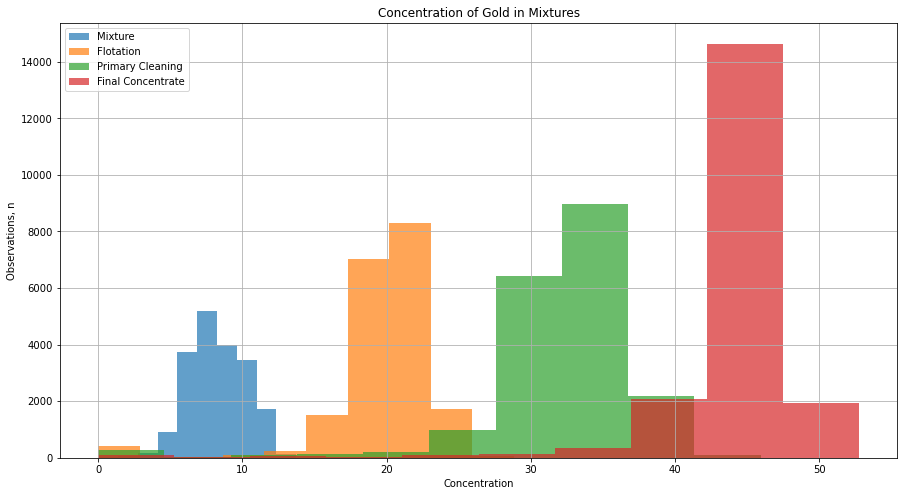

In [13]:
fig_metal(full_au, 'Gold')

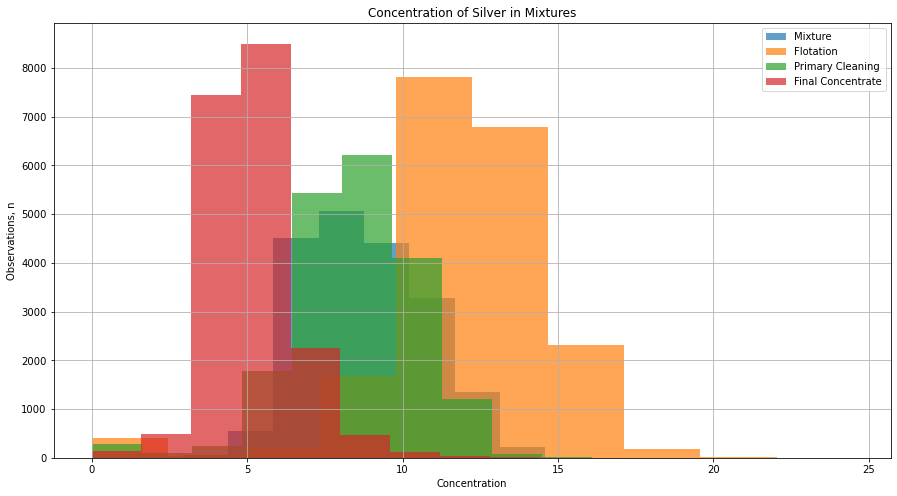

In [14]:
fig_metal(full_ag, 'Silver')

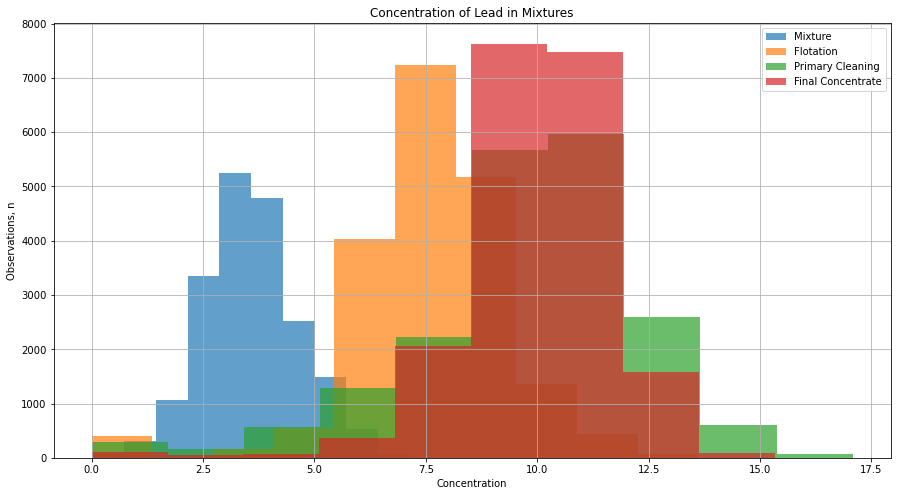

In [15]:
fig_metal(full_pb, 'Lead')

The most significant change is in the concentration of gold - it increases at each subsequent stage. After the final stage, the concentration of silver notably decreases, while that of lead increases after flotation and then remains roughly consistent.

### Comparison of Raw Material Granule Size Distribution in Training and Test Samples

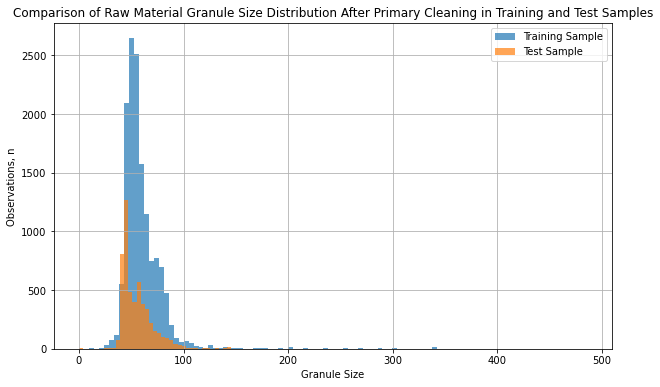

In [16]:
# Construct histograms (flotation stage)

train['rougher.input.feed_size'].hist(bins=100, alpha=0.7, label='Training Sample', figsize=(10,6))
test['rougher.input.feed_size'].hist(bins=100, alpha=0.7, label='Test Sample', figsize=(10,6))
plt.title('Comparison of Raw Material Granule Size Distribution After Primary Cleaning in Training and Test Samples')
plt.xlabel('Granule Size')
plt.ylabel('Observations, n')
plt.legend()
plt.show()

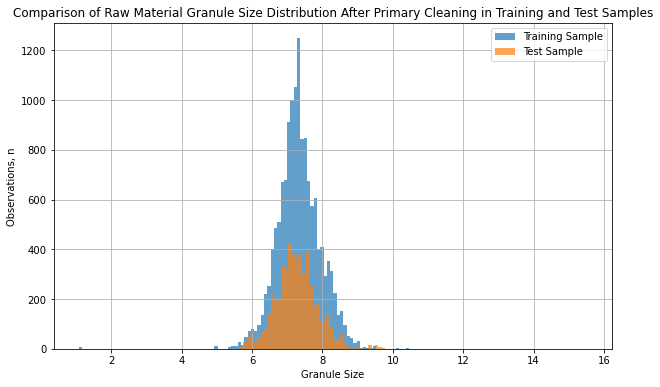

In [17]:
# Construct histograms (primary cleaning stage)

train['primary_cleaner.input.feed_size'].hist(bins=100, alpha=0.7, label='Training Sample', figsize=(10,6))
test['primary_cleaner.input.feed_size'].hist(bins=100, alpha=0.7, label='Test Sample', figsize=(10,6))
plt.title('Comparison of Raw Material Granule Size Distribution After Primary Cleaning in Training and Test Samples')
plt.xlabel('Granule Size')
plt.ylabel('Observations, n')
plt.legend()
plt.show()

In [18]:
# In general, the distributions are quite similar; for accuracy, one can conduct the Kolmogorov-Smirnov test.

print('Kolmogorov-Smirnov Test After Flotation Stage:')
print(ks_2samp(train['rougher.input.feed_size'], test['rougher.input.feed_size']))
print('')
print('Kolmogorov-Smirnov Test After Primary Cleaning Stage:')
print(ks_2samp(train['primary_cleaner.input.feed_size'], test['primary_cleaner.input.feed_size']))

Kolmogorov-Smirnov Test After Flotation Stage:
KstestResult(statistic=0.2502993057549405, pvalue=5.1997046130555955e-213)

Kolmogorov-Smirnov Test After Primary Cleaning Stage:
KstestResult(statistic=0.05922065470904381, pvalue=3.5273935105512727e-12)


Both from the graphs and the statistical test results (p<0.05), it's evident that the raw material granule size distribution after flotation and primary cleaning stages in the training and test samples don't differ. Therefore, there's no risk of an incorrect model assessment.

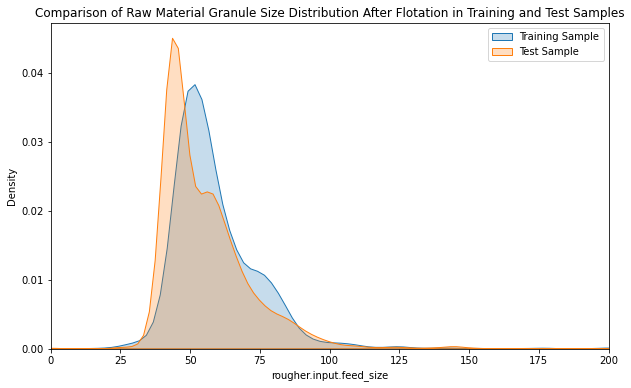

In [19]:
sns.kdeplot(train['rougher.input.feed_size'], shade=True, label='Training Sample')
sns.kdeplot(test['rougher.input.feed_size'], shade=True, label='Test Sample')
plt.ylim(0, None)
plt.xlim(0, 200)
plt.gcf().set_size_inches(10, 6)
plt.title('Comparison of Raw Material Granule Size Distribution After Flotation in Training and Test Samples')
plt.legend()
plt.show()

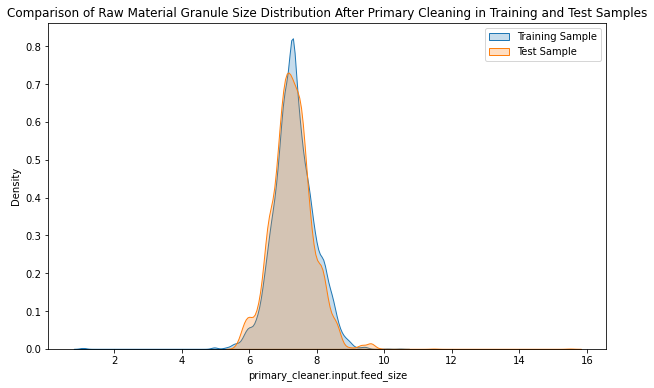

In [20]:
sns.kdeplot(train['primary_cleaner.input.feed_size'], shade=True, label='Training Sample')
sns.kdeplot(test['primary_cleaner.input.feed_size'], shade=True, label='Test Sample')
plt.gcf().set_size_inches(10, 6)
plt.title('Comparison of Raw Material Granule Size Distribution After Primary Cleaning in Training and Test Samples')
plt.legend()
plt.show()

### Total concentration of all substances at different stages

In [21]:
#In the complete dataset, we sum up all metals and salts at different stages:

#Mixture
full_rougher_input_feed_sum = (full['rougher.input.feed_au'] + full['rougher.input.feed_ag'] + 
                               full['rougher.input.feed_pb'] + full['rougher.input.feed_sol'])

#Flotation
full_rougher_output_concentrate_sum = (full['rougher.output.concentrate_au'] + full['rougher.output.concentrate_ag'] + 
                                        full['rougher.output.concentrate_pb'] + full['rougher.output.concentrate_sol'])

#Primary treatment
full_primary_cleaner_output_concentrate_sum = (full['primary_cleaner.output.concentrate_au'] + 
                                                full['primary_cleaner.output.concentrate_ag'] + 
                                                full['primary_cleaner.output.concentrate_pb'] +
                                                full['primary_cleaner.output.concentrate_sol'])

#Final stage
full_final_output_concentrate_sum = (full['final.output.concentrate_au'] + full['final.output.concentrate_ag'] + 
                                      full['final.output.concentrate_pb'] + full['final.output.concentrate_sol'])

#Create a dataframe for the graph
full_metal_sol = {'rougher_input_sum': full_rougher_input_feed_sum,
                  'rougher_output_sum': full_rougher_output_concentrate_sum,
                  'primary_cleaner_sum': full_primary_cleaner_output_concentrate_sum,
                  'final_sum': full_final_output_concentrate_sum}

full_metal_sol = pd.DataFrame(full_metal_sol)

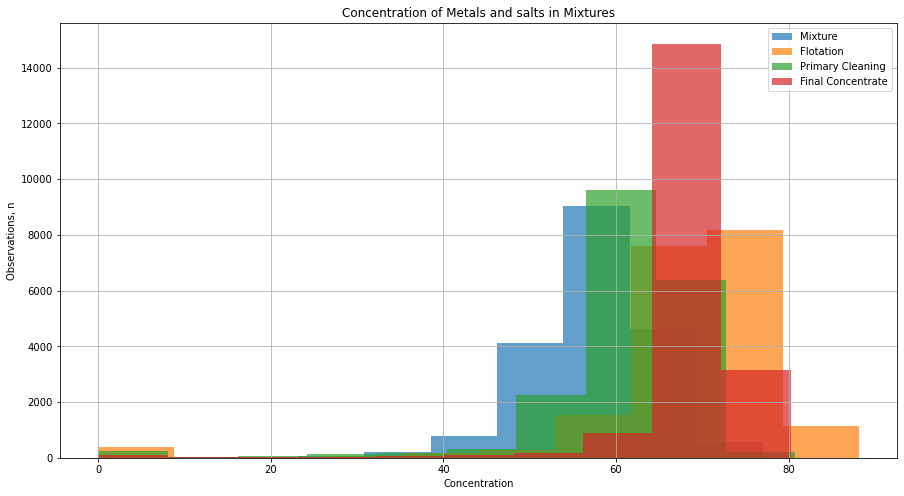

In [22]:
#Total concentration graph

fig_metal(full_metal_sol, 'Metals and salts')

We see that in the final concentrate, there is the highest total concentration of metals and salts. Importantly, we observe an anomaly - there are samples where the total concentration of metals and salts is negative, which is highly unlikely. As this can adversely affect model training, we will remove these data.

In [23]:
#Create a dataframe with the total amount of metals and salts for subsequent merging with the training sample.

train_rougher_input_feed_sum = (train['rougher.input.feed_au'] + train['rougher.input.feed_ag'] + 
                               train['rougher.input.feed_pb'] + train['rougher.input.feed_sol'])

train_rougher_output_concentrate_sum = (train['rougher.output.concentrate_au'] + 
                                       train['rougher.output.concentrate_ag'] +
                                       train['rougher.output.concentrate_pb'] + 
                                       train['rougher.output.concentrate_sol'])

train_primary_cleaner_output_concentrate_sum = (train['primary_cleaner.output.concentrate_au'] + 
                                                train['primary_cleaner.output.concentrate_ag'] + 
                                                train['primary_cleaner.output.concentrate_pb'] +
                                                train['primary_cleaner.output.concentrate_sol'])

train_final_output_concentrate_sum = (train['final.output.concentrate_au'] + 
                                           train['final.output.concentrate_ag'] +
                                           train['final.output.concentrate_pb'] +
                                           train['final.output.concentrate_sol'])

train_metal_sol_for_merge = {'date': train['date'],
                            'rougher_input_sum': train_rougher_input_feed_sum,
                            'rougher_output_sum': train_rougher_output_concentrate_sum,
                            'primary_cleaner_sum': train_primary_cleaner_output_concentrate_sum,
                            'final_sum': train_final_output_concentrate_sum}

train_metal_sol_for_merge = pd.DataFrame(train_metal_sol_for_merge)

#Merge by the "date" column

train_with_anomaly = train.merge(train_metal_sol_for_merge, on='date')

In [24]:
#Check the volume of the dataframe

train_with_anomaly.shape

(14149, 91)

In [25]:
#Retain data without abnormally low values

train_ex_anomaly = train_with_anomaly.query('rougher_input_sum > 1 and \
rougher_output_sum > 1 and \
primary_cleaner_sum > 1 and \
final_sum > 1')

In [26]:
# Recheck the dataframe's volume to ensure that the data is removed

train_ex_anomaly.shape

(13599, 91)

In [27]:
#Now, we can remove unnecessary features from the training sample that are absent in the test sample.
#The features "final.output.recovery" and "rougher.output.recovery" are essentially target ones, so we 
#cannot remove them from the training sample. We'll remove 
#those features absent in the test sample except the targets.

train_good = train_ex_anomaly.drop(columns=['final.output.concentrate_ag', 'final.output.concentrate_au',
 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.tail_ag',
 'final.output.tail_au', 'final.output.tail_pb', 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio', 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag', 'rougher.output.concentrate_au', 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol', 'rougher.output.tail_ag', 'rougher.output.tail_au',
 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_au', 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_sol', 'rougher_input_sum', 'rougher_output_sum', 
 'primary_cleaner_sum', 'final_sum'], axis=1)

In [28]:
#Conversely, we'll add target features from the complete dataset 
#to the test one, based on the "date" column.

test_good = test.merge(full.loc[:,['date','rougher.output.recovery','final.output.recovery']], on='date')

In [29]:
#Check the volumes of the resulting databases

print(train_good.shape)
test_good.shape

(13599, 55)


(5290, 55)

<b>Conclusions</b>

We analyzed the provided datasets. We noticed that with each subsequent processing stage, the concentration of gold significantly increases, which is essentially the processing goal. The distribution of raw material granule sizes after flotation and primary cleaning stages in the training and test samples are consistent. While analyzing the total concentration of metals and salts in mixtures, we found that there are samples with zero total concentration values. For more accurate model training, anomalous values have been removed. Databases are ready for use in model training.

## Model

### Preparation for Model Training

In [30]:
# Function to calculate sMAPE

def smape(target, predictions):
    
    return round(
        np.mean(
            np.abs(predictions - target) / 
            ((np.abs(predictions) + np.abs(target))/2)
        )*100, 3
    )

In [31]:
# Function to compute the final sMAPE

def smape_total(smape_rougher, smape_final):
    return (0.25*smape_rougher + 0.75*smape_final)

In [32]:
# Create a set of features and a target feature for each of the samples:

#Training
features_train = train_good.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train_rougher = train_good['rougher.output.recovery']
target_train_final = train_good['final.output.recovery']


# Testing
features_test = test_good.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test_rougher = test_good['rougher.output.recovery']
target_test_final = test_good['final.output.recovery']

In [33]:
# Scale the data using standardization

scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

### Model Training

In [34]:
# Decision tree

best_model_dt = None
best_result_dt = -20
best_depth_dt = 0
for depth in tqdm(range(1,20,2)):
    model_dt = DecisionTreeRegressor(random_state=12345, max_depth = depth)
    scorer = make_scorer(smape, greater_is_better=False)
    smape_rougher_tree = cross_val_score(model_dt, features_train, target_train_rougher, scoring=scorer, cv=5).mean()
    smape_final_tree = cross_val_score(model_dt, features_train, target_train_final, scoring=scorer, cv=5).mean()
    result_dt = smape_total(smape_rougher_tree, smape_final_tree)
    if result_dt > best_result_dt:
        best_model_dt = model_dt
        best_result_dt = result_dt
        best_depth_dt = depth
        
print('Final sMAPE of the best Decision Tree model on the validation sample:', 
      best_result_dt, 'at max_depth:', best_depth_dt)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  5.00s/it]

Final sMAPE of the best Decision Tree model on the validation sample: -8.6336 at max_depth: 3


In [35]:
# Random Forest

best_model_rf = None
best_result_rf = -20
best_depth_rf = 0
best_est_rf = 0
for est in tqdm(range(1,20,2)):
    for depth in range(1,20,2):
        model_rf = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        scorer = make_scorer(smape, greater_is_better=False)
        smape_rougher_forest = cross_val_score(model_rf, features_train, target_train_rougher, scoring=scorer, cv=5).mean()
        smape_final_forest = cross_val_score(model_rf, features_train, target_train_final, scoring=scorer, cv=5).mean()
        result_rf = smape_total(smape_rougher_forest, smape_final_forest)
        if result_rf > best_result_rf:
            best_model_rf = model_rf
            best_result_rf = result_rf
            best_depth_rf = depth
            best_est_rf = est

print('Final sMAPE of the best Random Forest model on the validation sample:', best_result_rf, 
      'at max_depth:', best_depth_rf, 'and n_estimators:', best_est_rf)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [34:11<00:00, 205.13s/it]

Final sMAPE of the best Random Forest model on the validation sample: -8.454950000000002 at max_depth: 5 and n_estimators: 19


In [36]:
# LinearRegression

model_lr = LinearRegression()
scorer = make_scorer(smape, greater_is_better=False)
smape_rougher_lr = cross_val_score(model_lr, features_train, target_train_rougher, scoring=scorer, cv=5).mean()
smape_final_lr =  cross_val_score(model_lr, features_train, target_train_final, scoring=scorer, cv=5).mean()
print('Final sMAPE of the best Random Forest model on the validation sample:', smape_total(smape_rougher_lr, smape_final_lr))

Final sMAPE of the best Random Forest model on the validation sample: -10.0911


The model that showed the value closest to 0 for the symmetric mean absolute percentage deviation was the Random Forest with max_depth and n_estimators at 19.

### Model Testing

In [37]:
#We found that the best model is the Random Forest. We test it on the test sample with previously identified best hyperparameters.

model_rf_test_rougher = RandomForestRegressor(random_state=12345, n_estimators=19, max_depth=5)
model_rf_test_final = RandomForestRegressor(random_state=12345, n_estimators=19, max_depth=5)
model_rf_test_rougher.fit(features_train, target_train_rougher)
model_rf_test_final.fit(features_train, target_train_final)
rf_predictions_test_rougher = model_rf_test_rougher.predict(features_test)
rf_predictions_test_final = model_rf_test_final.predict(features_test)
rf_smape_rougher = smape(target_test_rougher, rf_predictions_test_rougher)
rf_smape_final = smape(target_test_final, rf_predictions_test_final)
rf_smape_total = smape_total(rf_smape_rougher, rf_smape_final)
print(f'sMAPE on the test sample when using the Random Forest model: {rf_smape_total}')

sMAPE on the test sample when using the Random Forest model: 9.364


### Model Adequacy Test

In [38]:
# We create a Dummy model to assess the adequacy of the model.

dummy_model_rougher = DummyRegressor(strategy="mean")
dummy_model_final = DummyRegressor(strategy="mean")
dummy_model_rougher.fit(features_train, target_train_rougher)
dummy_model_final.fit(features_train, target_train_final)
dummy_predictions_model_rougher = dummy_model_rougher.predict(features_test)
dummy_predictions_model_final = dummy_model_final.predict(features_test)
dummy_smape_rougher = smape(target_test_rougher, dummy_predictions_model_rougher)
dummy_smape_final = smape(target_test_final, dummy_predictions_model_final)
dummy_smape_total = smape_total(dummy_smape_rougher, dummy_smape_final)
print(f'sMAPE of the Dummy model: {dummy_smape_total}')

sMAPE of the Dummy model: 9.8325


## Conclusion

Our task was to prepare a prototype machine learning model predicting the gold recovery coefficient from gold-bearing ore.

An initial data analysis was conducted. A relatively small amount of missing data was detected (0.1-0.3% of all data). They were filled using the method of duplicating the previous value. The correctness of the enrichment efficiency calculation was verified. We calculated the mean absolute error between the efficiency of enrichment calculated by us and the value of the feature rougher.output.recovery - the value turned out to be small, meaning the enrichment efficiency was calculated correctly.

It was confirmed that with each subsequent processing stage, the concentration of gold increases. The size of raw material granules after the flotation and primary cleaning stages in the training and test samples do not differ - there's no risk of the model being improperly evaluated. Also, anomalous values of some ore samples were identified, in which there is almost no concentration of any metals and salts. These samples were removed from the training database for more accurate model training.

Three models were trained - Decision Tree, Random Forest, and Logistic Regression. When assessing quality using cross-validation, the Random Forest model showed an sMAPE closest to zero. When testing the model on the test sample, it showed an sMAPE result of 9.364. Moreover, the Random Forest model passed the adequacy check - the Dummy model shows a greater symmetric mean absolute percentage deviation than our trained model.